# データ読込

In [1]:
import pandas as pd
from logic.factory_manage.utils.sql import load_data_from_sqlite
from utils.get_holydays import get_japanese_holidays

from utils.font import set_jp_font
set_jp_font()

# CSVファイル読み込み（パスは適宜変更）
path = "/work/app/data/factory_manage/weight_data.db"
df = load_data_from_sqlite()
df["伝票日付"].max()
df.head()

✅ 日本語フォントを設定しました: Noto Sans CJK JP


,伝票日付,品名,正味重量,祝日フラグ
0,2024-05-01,混合廃棄物A,1620.0,0
1,2024-05-01,混合廃棄物A,1840.0,0
2,2024-05-01,混合廃棄物A,1730.0,0
3,2024-05-01,混合廃棄物B,2000.0,0
4,2024-05-01,混合廃棄物A,360.0,0


### 2021年～

In [2]:
# pdは既にCELL INDEX:1でimportされているので、そのまま使えます
df_2021 = pd.read_csv("/work/app/data/input/2021顧客.csv", encoding="utf-8")
df_2022 = pd.read_csv("/work/app/data/input/2022顧客.csv", encoding="utf-8")
df_2023 = pd.read_csv("/work/app/data/input/2023_all.csv", encoding="utf-8")
df_2024 = pd.read_csv("/work/app/data/input/20240501-20250422.csv", encoding="utf-8")

df_2021 = df_2021[['伝票日付', '商品', '正味重量']]
df_2022 = df_2022[['伝票日付', '商品', '正味重量']]
df_2023 = df_2023[['伝票日付', '商品', '正味重量']]
df_2021.rename(columns={'商品': '品名'}, inplace=True)
df_2022.rename(columns={'商品': '品名'}, inplace=True)
df_2023.rename(columns={'商品': '品名'}, inplace=True)
df_2024 = df_2024[['伝票日付', '品名', '正味重量']]

df_all = pd.concat([df_2021, df_2022, df_2023, df_2024], ignore_index=True)
# 曜日など () を削除
df_all["伝票日付"] = df_all["伝票日付"].str.replace(r"\(.*\)", "", regex=True)
df_all["伝票日付"] = pd.to_datetime(df_all["伝票日付"], format="%Y/%m/%d")
df_all


/tmp/ipykernel_917982/4147401483.py:4: DtypeWarning: Columns (68) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2023 = pd.read_csv("/work/app/data/input/2023_all.csv", encoding="utf-8")


,伝票日付,品名,正味重量
0,2021-01-04,室内機,1440.0
1,2021-01-04,混合廃棄物A,1440.0
2,2021-01-04,室外機,1440.0
3,2021-01-05,混合廃棄物A,920.0
4,2021-01-05,混合廃棄物A,870.0
...,...,...,...
183774,2025-05-26,軽量物系A(ｽﾀｲﾛﾌｫｰﾑ),10.0
183775,2025-05-26,廃ﾌﾟﾗｽﾁｯｸ類,30.0
183776,2025-05-26,廃ﾌﾟﾗｽﾁｯｸ類,160.0
183777,2025-05-26,混合廃棄物A,2530.0


### 予約情報

In [3]:
df_reserve = pd.read_csv(
    "/work/app/data/input/yoyaku_data.csv")
df_reserve["予約日"] = pd.to_datetime(df_reserve["予約日"])
df_reserve.rename(columns={"台数": "予約台数"}, inplace=True)
print(df_reserve["予約日"].min(), df_reserve["予約日"].max())
print(df_reserve.columns)
df_reserve

2023-01-04 00:00:00 2025-05-31 00:00:00
Index(['予約日', '予約得意先名', '固定客', '予約台数'], dtype='object')


,予約日,予約得意先名,固定客,予約台数
0,2023-01-04,アンデス,False,1.0
1,2023-01-04,リサイクルレスキュー,False,1.0
2,2023-01-04,山口興業,False,2.0
3,2023-01-04,明和建装,False,1.0
4,2023-01-04,まごころ清掃社,False,1.0
...,...,...,...,...
45726,2025-05-31,首都高メンテナンス,False,1.0
45727,2025-05-31,シミズオクト,False,1.0
45728,2025-05-31,鈴亀,False,1.0
45729,2025-05-31,鈴木運輸,True,1.0


### 受入番号用

In [4]:
import os
import glob
import pandas as pd

# ディレクトリ内の全CSVファイルパスを取得
csv_dir = "/work/app/data/input/受入_時刻"
csv_files = glob.glob(os.path.join(csv_dir, "*.csv"))

# 全CSVを読み込んで結合
dfs = []
for f in csv_files:
    df_tmp = pd.read_csv(f)

    # 伝票日付を整形 → 日付型へ変換
    df_tmp["伝票日付"] = df_tmp["伝票日付"].str.replace(r"\(.*?\)", "", regex=True).str.strip()
    df_tmp["伝票日付"] = pd.to_datetime(df_tmp["伝票日付"], format="%Y/%m/%d")

    # 正味重量をカンマ除去して数値化
    df_tmp["正味重量"] = df_tmp["正味重量"].replace({',': ''}, regex=True).astype(float)

    # 受入番号の欠損を埋めて型変換（念のため）
    df_tmp["受入番号"] = df_tmp["受入番号"].fillna(-1).astype(int)

    dfs.append(df_tmp)

df_Ukeire = pd.concat(dfs, ignore_index=True)

# 必要カラムだけ抽出（品名・重量・受入番号）
df_Ukeire = df_Ukeire[["伝票日付", "品名", "正味重量", "受入番号"]].copy()

# 台数カウント準備（日付・品名ごとの受入番号ユニーク数）
df_count = (
    df_Ukeire.groupby(["伝票日付", "品名"])["受入番号"]
    .nunique()
    .reset_index()
    .rename(columns={"受入番号": "台数"})
)

# （参考）結合しておく場合
df_merged = pd.merge(df_Ukeire, df_count, on=["伝票日付", "品名"], how="left")

# リネーム
df_merged.rename(columns={"台数": "搬入済台数"}, inplace=True)

# 結果確認
df_merged


,伝票日付,品名,正味重量,受入番号,搬入済台数
0,2025-06-01,混合廃棄物A,1110.0,54050,35
1,2025-06-01,混合廃棄物A,120.0,54094,35
2,2025-06-01,混合廃棄物A,270.0,54060,35
3,2025-06-01,混合廃棄物A,1220.0,54044,35
4,2025-06-01,混合廃棄物A,1650.0,54089,35
...,...,...,...,...,...
64680,2024-11-30,混合廃棄物A,50.0,31824,74
64681,2024-11-30,混合廃棄物A,310.0,31822,74
64682,2024-11-30,混合廃棄物A,1140.0,31805,74
64683,2024-11-30,木くず,870.0,31824,9


In [5]:
target_items = ["混合廃棄物A", "混合廃棄物B", "GC 軽鉄･ｽﾁｰﾙ類", "選別", "木くず"]

# モデル作成・失敗


In [ ]:
# # 最初のモデル
from logic.factory_manage.predict_model_v4_4 import full_walkforward_pipeline

all_actual, all_pred  = full_walkforward_pipeline(
    df
)

# print_metrics(all_actual, all_pred)

In [ ]:
# # 最初のモデル・修正・未来リークなし
from logic.factory_manage.predict_model_v4_4_fix1 import full_walkforward_pipeline

all_actual, all_pred  = full_walkforward_pipeline(
    df
)

# print_metrics(all_actual, all_pred)

In [ ]:
# 交差検証パイプライン
from logic.factory_manage.predict_model_v4_5 import cross_validation_pipeline
    
pred_df_slim = cross_validation_pipeline(
    df,
    n_splits=5,)


In [ ]:
## 最適履歴データ数
from logic.factory_manage.predict_model_v4_5 import prepare_history_data,full_walkforward_pipeline,print_metrics

window_list = [180,240,360]

for history_days in window_list:
    df_input = prepare_history_data(df, history_days=history_days)
    if df_input is not None:
        all_actual, all_pred = full_walkforward_pipeline(df_input, start_index=30)
        print(f"\n履歴日数: {history_days}日")
        print_metrics(all_actual, all_pred)


# 真モデル

### 初期モデル

In [ ]:
# 過去5年分のデータ
# 最初のモデル
from logic.factory_manage.old_model1.predict_model_v4_2_1 import full_walkforward

hol_max_all = df["伝票日付"].max()
hol_min_all = df["伝票日付"].min()
print(f"最小日付: {hol_min_all}, 最大日付: {hol_max_all}")
holiday_all = get_japanese_holidays(hol_min_all, hol_max_all)

full_walkforward(
    df_all,
    holidays=holiday_all,
    top_n=2
)



#### 結果  
===== ステージ2評価結果 (全体合計) =====  
R² = 0.640, MAE = 8,457kg

===== ステージ1評価結果 =====  
混合廃棄物A: R² = 0.585, MAE = 7,572kg  
混合廃棄物B: R² = 0.377, MAE = 3,070kg

### 初期モデル_失敗


=== 330日分のデータで評価中 ===
▶️ full_walkforward 開始
📌 入力データ件数: 51768

=== 2024-08-10 を予測中 ===
▶️ train_and_predict_stage1 開始
📌 df_feat_today index: DatetimeIndex(['2024-08-10'], dtype='datetime64[ns]', name='伝票日付', freq=None)
📌 学習用特徴量サイズ: (30, 21)
📌 学習用pivotサイズ: (30, 244)
❌ エラー: "['平均気温', '降水量'] not in index"

=== 評価結果 ===
   days    R2   MAE
0   330  None  None


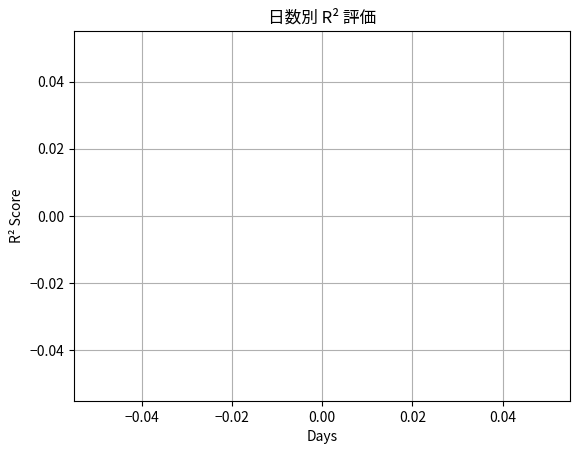

In [7]:
from logic.factory_manage.old_model1.predict_model_v4_2_2 import generate_reserve_features, full_walkforward
import pandas as pd

# ---------- 予約特徴量生成 ----------
df_reserve_feat = generate_reserve_features(df_reserve)

# 対象日：予約日と一致する日だけ残す
reserve_dates = df_reserve_feat.index
df_all["伝票日付"] = pd.to_datetime(df_all["伝票日付"])  # 念のため変換
valid_dates = df_all["伝票日付"].isin(reserve_dates)
df_all = df_all[valid_dates].copy()

# ---------- 最新から〇日分に制限 ----------
from sklearn.metrics import r2_score, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt

# 評価対象のdaysリスト
days_list = [330]
results = []

for days in days_list:
    print(f"\n=== {days}日分のデータで評価中 ===")

    latest_date = df_all["伝票日付"].max()
    cutoff_date = latest_date - pd.Timedelta(days=days)
    df_subset = df_all[df_all["伝票日付"] >= cutoff_date].copy()

    hol_max = df_subset["伝票日付"].max()
    hol_min = df_subset["伝票日付"].min()
    holidays = get_japanese_holidays(hol_min, hol_max)

    try:
        actual, pred = full_walkforward(
            df_subset,
            df_reserve=df_reserve,
            holidays=holidays,
            top_n=2
        )
        if actual and pred:
            r2 = r2_score(actual, pred)
            mae = mean_absolute_error(actual, pred)
            results.append((days, r2, mae))
            print(f"✅ R² = {r2:.3f}, MAE = {mae:,.0f}kg")
        else:
            print("⚠ 評価に十分なデータがありません")
    except Exception as e:
        print(f"❌ エラー: {e}")
        results.append((days, None, None))

# 結果表示
df_result = pd.DataFrame(results, columns=["days", "R2", "MAE"])
print("\n=== 評価結果 ===")
print(df_result)

# 可視化（任意）
plt.plot(df_result["days"], df_result["R2"], marker="o")
plt.xlabel("Days")
plt.ylabel("R² Score")
plt.title("日数別 R² 評価")
plt.grid(True)
plt.show()

## 予約数の追加モデル


=== 300日分のデータで評価中 ===
▶️ full_walkforward 開始

=== 2024-09-12 を予測中 ===

▶️ train_and_predict_stage1 開始
🛠 モデル訓練中: elastic for 混合廃棄物A
🛠 モデル訓練中: rf for 混合廃棄物A
🛠 モデル訓練中: elastic for 混合廃棄物B
🛠 モデル訓練中: rf for 混合廃棄物B

=== 2024-09-13 を予測中 ===

▶️ train_and_predict_stage1 開始
🛠 モデル訓練中: elastic for 混合廃棄物A
🛠 モデル訓練中: rf for 混合廃棄物A
🛠 モデル訓練中: elastic for 混合廃棄物B
🛠 モデル訓練中: rf for 混合廃棄物B

=== 2024-09-14 を予測中 ===

▶️ train_and_predict_stage1 開始
🛠 モデル訓練中: elastic for 混合廃棄物A
🛠 モデル訓練中: rf for 混合廃棄物A
🛠 モデル訓練中: elastic for 混合廃棄物B
🛠 モデル訓練中: rf for 混合廃棄物B

=== 2024-09-15 を予測中 ===

▶️ train_and_predict_stage1 開始
🛠 モデル訓練中: elastic for 混合廃棄物A
🛠 モデル訓練中: rf for 混合廃棄物A
🛠 モデル訓練中: elastic for 混合廃棄物B
🛠 モデル訓練中: rf for 混合廃棄物B

=== 2024-09-16 を予測中 ===

▶️ train_and_predict_stage1 開始
🛠 モデル訓練中: elastic for 混合廃棄物A
🛠 モデル訓練中: rf for 混合廃棄物A
🛠 モデル訓練中: elastic for 混合廃棄物B
🛠 モデル訓練中: rf for 混合廃棄物B

=== 2024-09-17 を予測中 ===

▶️ train_and_predict_stage1 開始
🛠 モデル訓練中: elastic for 混合廃棄物A
🛠 モデル訓練中: rf for 混合廃棄物A
🛠 モデル訓練中: elastic for 混合廃棄物B


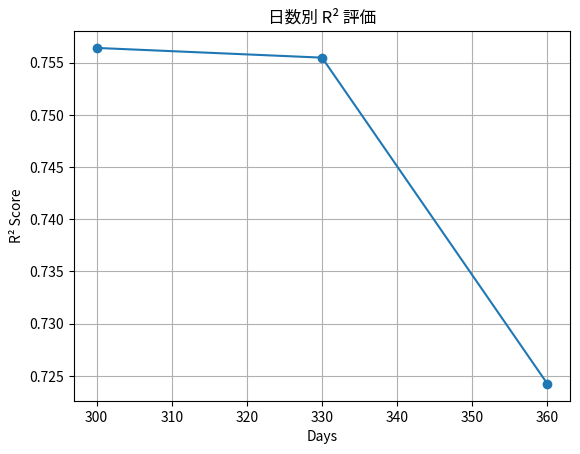

In [8]:
from logic.factory_manage.new_model1.predict_model_v4_2_4 import full_walkforward
from logic.factory_manage.new_model1.feature_builder import ReserveFeatureBuilder
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# ---------- 予約特徴量生成 ----------
df_reserve_feat = ReserveFeatureBuilder(df_reserve).build()

# 対象日：予約日と一致する日だけ残す
reserve_dates = df_reserve_feat.index
df_all["伝票日付"] = pd.to_datetime(df_all["伝票日付"])  # 念のため変換
df_all = df_all[df_all["伝票日付"].isin(reserve_dates)].copy()

# ---------- 最新から〇日分に制限 ----------
days_list = [300, 330, 360]
results = []

for days in days_list:
    print(f"\n=== {days}日分のデータで評価中 ===")
    
    latest_date = df_all["伝票日付"].max()
    cutoff_date = latest_date - pd.Timedelta(days=days)
    df_subset = df_all[df_all["伝票日付"] >= cutoff_date].copy()
    
    hol_max = df_subset["伝票日付"].max()
    hol_min = df_subset["伝票日付"].min()
    holidays = get_japanese_holidays(hol_min, hol_max)
    
    try:
        actual, pred = full_walkforward(
            df_subset,
            df_reserve=df_reserve,
            holidays=holidays,
            min_stage1_days=30,
            min_stage2_days=15,
            top_n=2
        )
        if actual and pred:
            r2 = r2_score(actual, pred)
            mae = mean_absolute_error(actual, pred)
            results.append((days, r2, mae))
            print(f"✅ R² = {r2:.3f}, MAE = {mae:,.0f}kg")
        else:
            print("⚠ 評価に十分なデータがありません")
    except Exception as e:
        print(f"❌ エラー: {e}")
        results.append((days, None, None))

# 結果表示
df_result = pd.DataFrame(results, columns=["days", "R2", "MAE"])
print("\n=== 評価結果 ===")
print(df_result)

# 可視化（任意）
plt.plot(df_result["days"], df_result["R2"], marker="o")
plt.xlabel("Days")
plt.ylabel("R² Score")
plt.title("日数別 R² 評価")
plt.grid(True)
plt.show()


## 天気追加モデル

In [ ]:
from logic.factory_manage.new_model2.predict_model_v4_2_4 import full_walkforward
from utils.get_holydays import get_japanese_holidays
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from logic.factory_manage.new_model2.feature_builder import WeatherFeatureBuilder, ReserveFeatureBuilder

# ---------- 予約特徴量生成 ----------
df_reserve_feat = ReserveFeatureBuilder(df_reserve).build()

# 対象日：予約日と一致する日だけ残す
df_all["伝票日付"] = pd.to_datetime(df_all["伝票日付"])
reserve_dates = df_reserve_feat.index

# ---------- 最新から〇日分に制限 ----------
days_list = [300, 330, 360]
results = []

for days in days_list:
    print(f"\n=== {days}日分のデータで評価中 ===")

    latest_date = df_all["伝票日付"].max()
    cutoff_date = latest_date - pd.Timedelta(days=days)
    df_subset = df_all[df_all["伝票日付"] >= cutoff_date].copy()

    hol_min = df_subset["伝票日付"].min()
    hol_max = df_subset["伝票日付"].max()
    holidays = get_japanese_holidays(hol_min, hol_max)

    df_reserve_subset = df_reserve_feat.loc[hol_min:hol_max].copy()

    weather_builder = WeatherFeatureBuilder(start_date=hol_min, end_date=hol_max)
    df_weather = weather_builder.build().loc[hol_min:hol_max].copy()

    try:
        actual, pred = full_walkforward(
            df_raw=df_subset,
            df_reserve=df_reserve_subset,
            holidays=holidays,
            df_weather=df_weather,
            min_stage1_days=30,
            min_stage2_days=15,
            top_n=2
        )
        if actual and pred:
            r2 = r2_score(actual, pred)
            mae = mean_absolute_error(actual, pred)
            results.append((days, r2, mae))
            print(f"✅ R² = {r2:.3f}, MAE = {mae:,.0f}kg")
        else:
            print("⚠ 評価に十分なデータがありません")
    except Exception as e:
        print(f"❌ エラー: {e}")
        results.append((days, None, None))

# ---------- 結果表示 ----------
df_result = pd.DataFrame(results, columns=["days", "R2", "MAE"])
print("\n=== 評価結果 ===")
print(df_result)

# ---------- 可視化 ----------
plt.plot(df_result["days"], df_result["R2"], marker="o")
plt.xlabel("Days")
plt.ylabel("R² Score")
plt.title("日数別 R² 評価")
plt.grid(True)
plt.show()


KeyError: '予約日'